# DS5110 Final Project Assignment

## The Ed Squad
Shilpa Narayan (smn7ba) <br>
Ashlie Assege (ajo5fs) <br>
Jamie Oh (hso6b) <br>
Isaac Stevens (is3sb) <br>

### About data
AMERICAN COMMUNITY SURVEY 2015-2019 5-YEAR SAMPLE
5-in-100 national random sample of the population
Contains all households and persons from the 1% ACS samples for 2015, 2016, 2017, 2018, and 2019 identifiable by year.
The data include persons in group quarters.
This is a weighted sample.
The smallest identifiable geographic unit is the PUMA, containing at least 100,000 persons. PUMAs do not cross state boundaries.
Users should read the FAQ on the multi-year data.

WHERE CAN I GET BETTER GEOGRAPHIC IDENTIFIERS?
The lowest unit of geography in the microdata files is still the PUMA. PUMAs contain at least 100,000 people.
Aggregate data (but not microdata) is currently available from the Census Bureau for geographic areas as small as block groups, but only for the entire 2005-2009 period.

PERNUM numbers all persons within each household consecutively in the order in which they appear on the original census or survey form.
When combined with SAMPLE and SERIAL, PERNUM uniquely identifies each person within the IPUMS.

MULTYEAR identifies the actual year of survey in multi-year ACS/PRCS samples.


For example, the 3-year ACS and PRCS data files each include cases from three single-year files.
For these multi-year samples, the YEAR variable identifies the last year of data (2007 for the 2005-2007 3-year data; 2008 for the 2006-2008 data; and so on).
MULTYEAR gives the single-year sample from which the case was drawn (2005, 2006, or 2007 for the 2005-2007 3-year data; 2006, 2007, or 2008 for the 2006-2008 3-year data; and so on).

https://usa.ipums.org/usa/acs_multyr.shtml

In [1]:
#import spark packages
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext
#import mlLib libraries for classification
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [2]:
#import python packages too for visualizations
%matplotlib inline
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 200000)

In [3]:
#set seed so results are reproducible
seed = 42

In [4]:
# set up the spark session
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Ed Squad Project") \
    .config("spark.executor.memory", '200g') \
    .config('spark.executor.cores', '6') \
    .config('spark.cores.max', '8')\
    .config("spark.driver.memory",'32g') \
    .getOrCreate()

sc = spark.sparkContext    
sqlContext = SQLContext(spark)

## Read In Data

In [5]:
%%time
#import whole data from the census
data = spark.read.csv('/project/ds5559/ds5110_project_snoo/acs_15_19_south.csv', inferSchema="true", header="true")

CPU times: user 13 ms, sys: 13 ms, total: 26 ms
Wall time: 1min 53s


## Preprocess Data

In [6]:
#writing a user defined function to create a Educated or Not label - if EDUC>6 then it is 1 and if not 0
def EDUCFunc(value):
  if   value > 6: 
      return 1
  else:
      return 0

#call the function to be applied and create a new column EDUC_FLAG
udfsomefunc = F.udf(EDUCFunc, IntegerType())
data = data.withColumn("label", udfsomefunc("EDUC"))
#see sample data
data.select('label').distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [7]:
%%time
#check the count for EDUC>6 or verify if flag was populated correctly
data.filter(data.EDUC>6).count()

CPU times: user 4.04 ms, sys: 3.58 ms, total: 7.62 ms
Wall time: 37 s


2470127

In [8]:
%%time
#Verify the flag count. Should match number above
data.filter(data.label!=0).count()

CPU times: user 4.88 ms, sys: 2.78 ms, total: 7.66 ms
Wall time: 39.8 s


2470127

### Balance the data for similar number of EDUC FLAG

In [9]:
#majority sample is for larger class when we use a ratio by sampling smaller class count out of larger class count
sampled_majority_df = data.filter(data['label']==0)\
    .sample(False,data.filter(data['label']==1).count()/data.filter(data['label']==0).count(), seed=seed)
#minor sample is kept as is
minor_df = data.filter(data['label']==1).sample(False,1.0, seed=seed)
#combine both in a dataframe for a balanced sample
df = sampled_majority_df.unionAll(minor_df)

In [10]:
#check results
df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|2470127|
|    0|2470573|
+-----+-------+



## EDA

### Full Data EDA

In [70]:
#displaying number of rows and columns in the data
print((data.count(), len(data.columns)))

(5965249, 206)


In [72]:
#number of years in the data set
data.select('MULTYEAR').distinct().sort('MULTYEAR').show()

+--------+
|MULTYEAR|
+--------+
|    2015|
|    2016|
|    2017|
|    2018|
|    2019|
+--------+



### Education EDA

In [73]:
'''
Education field - we made a binary variable (above 6, and below)
EDUC                Educational attainment [general version]
00                  N/A or no schooling
01                  Nursery school to grade 4
02                  Grade 5, 6, 7, or 8
03                  Grade 9
04                  Grade 10
05                  Grade 11
06                  Grade 12
07                  1 year of college
08                  2 years of college
09                  3 years of college
10                  4 years of college
11                  5+ years of college
'''

'\nEducation field - we made a binary variable (above 6, and below)\nEDUC                Educational attainment [general version]\n00                  N/A or no schooling\n01                  Nursery school to grade 4\n02                  Grade 5, 6, 7, or 8\n03                  Grade 9\n04                  Grade 10\n05                  Grade 11\n06                  Grade 12\n07                  1 year of college\n08                  2 years of college\n09                  3 years of college\n10                  4 years of college\n11                  5+ years of college\n'

In [76]:
data.select('EDUC').distinct().orderBy('EDUC').show()

+----+
|EDUC|
+----+
|   0|
|   1|
|   2|
|   3|
|   4|
|   5|
|   6|
|   7|
|   8|
|  10|
|  11|
+----+



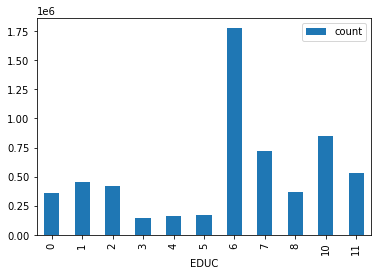

In [77]:
data_edu = data.groupby('EDUC').count().orderBy('EDUC')
data_edu = data_edu.toPandas()
data_edu.plot(x="EDUC", y="count", kind='bar')
plt.show() # no 9's!

### Gender EDA

In [78]:
'''
SEX                 Sex
1                   Male
2                   Female
'''

'\nSEX                 Sex\n1                   Male\n2                   Female\n'

In [79]:
data.groupBy('SEX').count().show()

+---+-------+
|SEX|  count|
+---+-------+
|  1|2897686|
|  2|3067563|
+---+-------+



In [80]:
male_0 = data[(data['SEX'] == 1) & (data['label'] == 0)].count()
male_1 = data[(data['SEX'] == 1) & (data['label'] == 1)].count()
female_0 = data[(data['SEX'] == 2) & (data['label'] == 0)].count()
female_1 = data[(data['SEX'] == 2) & (data['label'] == 1)].count()
male = male_0 + male_1
female = female_0 + female_1
total = male + female
total, data.count()

(5965249, 5965249)

In [81]:
# Male - Ed 0 vs Ed 1
male_0/(male_0+male_1), male_1/(male_0+male_1)

(0.6060601459233333, 0.3939398540766667)

In [82]:
# Female - Ed 0 vs Ed 1
female_0/(female_0+female_1), female_1/(female_0+female_1)

(0.5668832229362527, 0.43311677706374735)

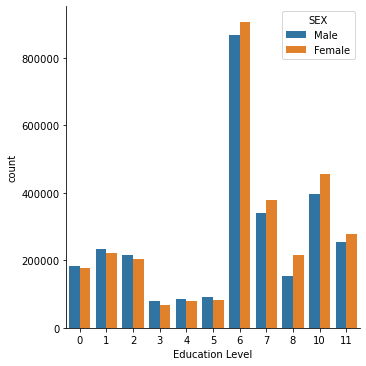

In [83]:
df2 = data.groupBy('EDUC', 'SEX').count().orderBy('EDUC', 'SEX')
df2 = df2.toPandas()
fg = sns.catplot(x='EDUC', y='count', hue='SEX', data=df2, kind='bar', legend_out=False)
fg.set_xlabels('Education Level')

new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new)

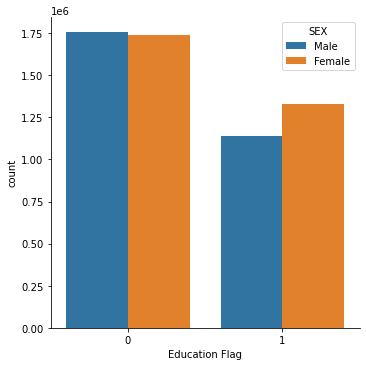

In [84]:
df3 = data.groupBy('label', 'SEX').count().orderBy('label', 'SEX')
df3 = df3.toPandas()
fg = sns.catplot(x='label', y='count', hue='SEX', data=df3, kind='bar', legend_out=False)
fg.set_xlabels('Education Flag')

new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new)

## EDA On Sampled Data

In [23]:
#removing cols which are repeated and may be highly correlated so that PCA components are more meaningful
cols = df.drop('_c0','EDUC','CLUSTER','CBSERIAL','STRATA','HHWT','EDUCD',\
 'QCOSTELE',\
 'QCOSTFUE',\
 'QCOSTGAS',\
 'QCOSTWAT',\
 'QFOODSTM',\
 'QINSINCL',\
 'QMORTGAG',\
 'QOWNERSH',\
 'QPROPINS',\
 'QTAXINCL',\
 'QVALUEH',\
 'QFUELHEA',\
 'QCIDIAL',\
 'QCILAPTOP',\
 'QCINETHH',\
 'QCIOTHSVC',\
 'QCISAT',\
 'QCISMRTPHN',\
 'QCITABLET',\
 'QCIDATAPLN',\
 'QVEHICLE',\
 'QAGE',\
 'QMARRNO',\
 'QMARST',\
 'QRELATE',\
 'QSEX',\
 'QYRMARR',\
 'QBPL',\
 'QCITIZEN',\
 'QHISPAN',\
 'QRACE',\
 'QYRNATUR',\
 'QHINSEMP',\
 'QHINSPUR',\
 'QHINSTRI',\
 'QHINSCAI',\
 'QHINSCAR',\
 'QHINSVA',\
 'QHINSIHS',\
 'QEDUC',\
 'QGRADEAT',\
 'QDEGFIELD',\
 'QSCHOOL',\
 'QCLASSWK',\
 'QEMPSTAT',\
 'QIND',\
 'QOCC',\
 'QUHRSWOR',\
 'QINCEARN',\
 'QINCBUS',\
 'QINCINVS',\
 'QINCOTHE',\
 'QINCRETI',\
 'QINCSS',\
 'QINCSUPP',\
 'QINCTOT',\
 'QFTOTINC',\
 'QINCWAGE',\
 'QINCWELF',\
 'QVETSTAT',\
 'QCARPOOL',\
 'QDEPARTS',\
 'QPWSTAT2',\
 'QRIDERS',\
 'QTRANTIM',\
 'QTRANWOR',\
 'QGCHOUSE',\
 'QGCMONTH',\
 'QGCRESPO',\
 'INCSUPP',\
 'INCWAGE',\
 'INCBUS00',\
 'INCSS',\
 'INCWELFR',\
 'INCINVST',\
 'INCRETIR',\
 'INCSUPP',\
 'INCOTHER',\
 'INCEARN',\
 'RACE',\
 'RACED',\
 'SEI',\
 'CLASSWKRD',\
 'GRADEATTD',\
 'EMPSTATD',\
 'MULTGEND',\
 'OWNERSHPD',\
 'BPLD',\
 'YEAR','SAMPLE','SERIAL','PERNUM','MULTYEAR').columns

In [24]:
def createSampleData(df,cols,sampleweight):
    '''
    function to create a sample of the data based on certain columns and a sample weight
    '''
    df_small = df.select(cols)
    sampled = df_small.sampleBy("MULTYEAR", fractions={2015:sampleweight, 2016: sampleweight, 2017:sampleweight, 2018:sampleweight, 2019:sampleweight}, seed=seed)
    return sampled

In [25]:
#creating sampled dataset (sampled)
selected_cols=[cols for cols in cols if cols not in['label']]
sampled = createSampleData(df,cols,0.1)

In [26]:
hhtype_groups = df.groupBy("HHTYPE").count().sort(col("count").desc())

In [27]:
#udf to map hhtype
def mapHhtype(value):
    hhtype_dict = {0:'N/A',\
            1: 'Married-couple family household',\
            2: 'Male householder, no wife present',\
            3: 'Female householder, no husband present',\
            4: 'Male householder, living alone',\
            5: 'Male householder, not living alone',\
            6: 'Female householder, living alone',\
            7: 'Female householder, not living alone',\
            9: 'HHTYPE could not be determined'}
    return hhtype_dict.get(value)

In [28]:
hhtype_function = F.udf(mapHhtype, StringType())
hhtype_groups = hhtype_groups.withColumn("hhtype_long", hhtype_function("hhtype"))
hhtype_df = hhtype_groups.toPandas()

In [29]:
hhtype_df

,HHTYPE,count,hhtype_long
0,1,2976178,Married-couple family household
1,3,592327,"Female householder, no husband present"
2,6,334857,"Female householder, living alone"
3,9,288258,HHTYPE could not be determined
4,4,240305,"Male householder, living alone"
5,0,220227,N/A
6,2,166171,"Male householder, no wife present"
7,5,66521,"Male householder, not living alone"
8,7,55856,"Female householder, not living alone"


<AxesSubplot:title={'center':'House Hold Types Ordered by Count'}, xlabel='hhtype_long'>

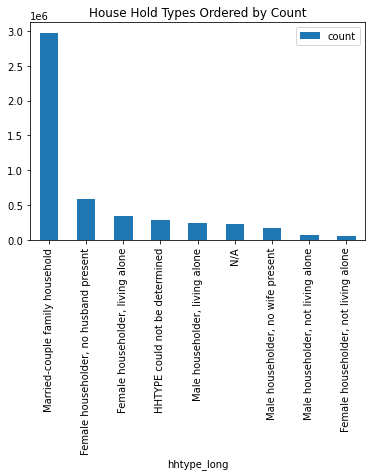

In [30]:
hhtype_df.plot.bar(x='hhtype_long', y='count', title = "House Hold Types Ordered by Count")

In [31]:
%%time
corr_df = sampled.toPandas()[selected_cols]

CPU times: user 19.4 s, sys: 1.97 s, total: 21.4 s
Wall time: 3min


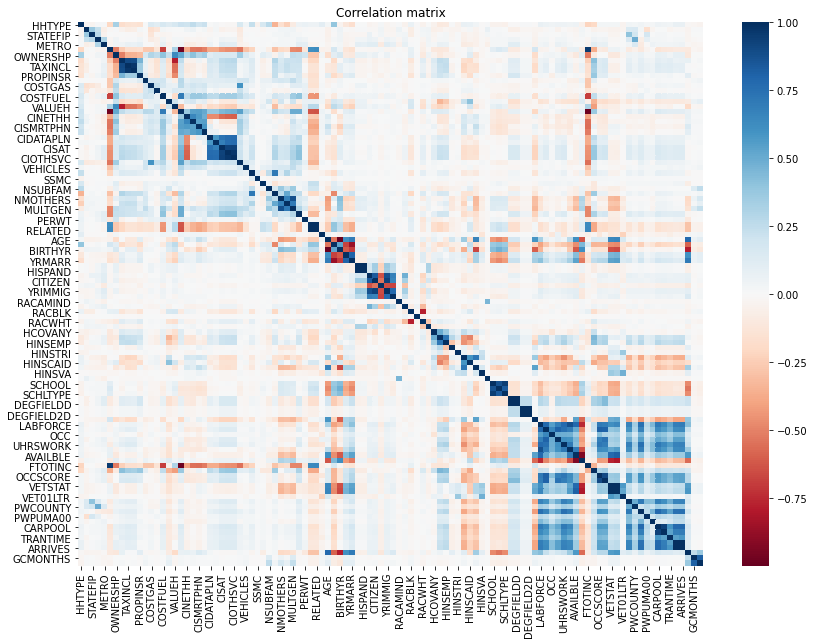

In [32]:
#View Correlation
corr = corr_df.corr()
plt.figure(figsize = (14, 10))
sns.heatmap(corr, cmap="RdBu",annot = False)
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values)
plt.title('Correlation matrix')
plt.show()

## Model Construction

### Baseline Logistic Regression Model With Only 36 Features

In [33]:
#Select Only These 36 Features for Baseline Model
roi = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP",
       "CINETHH","CILAPTOP", "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS",
       "CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS" ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT",
       "LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","label"]

In [34]:
sampled_roi = sampled.select(roi)

In [35]:
#Assemble Features using VectorAssembler
baseline_assembler = VectorAssembler(inputCols=[column for column in roi if column not in ["label"]], outputCol="features") 
baseline_tr = baseline_assembler.transform(sampled_roi)

#train test split
baseline_training, baseline_test = baseline_tr.randomSplit([0.7, 0.3], seed=314)

#declare model
lr_baseline = LogisticRegression(labelCol='label',
                        featuresCol='features',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

#Fit model
lrModel_baseline = lr_baseline.fit(baseline_training)

#Predict on test data
lrPred_baseline = lrModel_baseline.transform(baseline_test)

### Evaluate Baseline Model

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
def createLabelsCMandPlot(preds):
    
    ##saving labels in a list to pass to the plot
    class_temp = preds.select("label").groupBy("label")\
                            .count().sort('count', ascending=False).toPandas()
    class_temp = class_temp["label"].values.tolist()
    y_true = preds.select("label")
    y_true = y_true.toPandas()

    y_pred = preds.select("prediction")
    y_pred = y_pred.toPandas()
    
    plot_confusion_matrix(confusion_matrix(y_true, y_pred,class_temp), classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


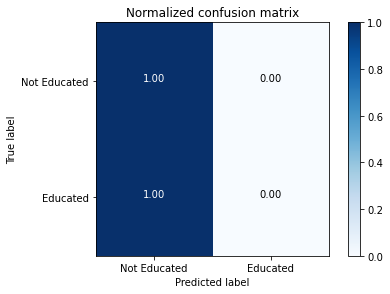

In [39]:
createLabelsCMandPlot(lrPred_baseline)

In [40]:
def classificationMetrics(preds):
    #calcualte classification report
    TN = preds.filter('prediction = 0 AND label = prediction').count()
    TP = preds.filter('prediction = 1 AND label = prediction').count()
    FN = preds.filter('prediction = 0 AND label <> prediction').count()
    FP = preds.filter('prediction = 1 AND label <> prediction').count()
    # show confusion matrix
    preds.groupBy('label', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    if precision + recall == 0:
        F = 0
    else:
        F =  2 * (precision*recall) / (precision + recall)
    # calculate auc
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="label",
                                          metricName="areaUnderPR")
    auc = evaluator.evaluate(preds)
    print('precision: %0.3f' % precision)
    print('recall: %0.3f' % recall)
    print('accuracy: %0.3f' % accuracy)
    print('F1 score: %0.3f' % F)
    print('AUC: %0.3f' % auc)

In [41]:
classificationMetrics(lrPred_baseline)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|74071|
|    0|       0.0|74335|
+-----+----------+-----+

precision: 0.000
recall: 0.000
accuracy: 0.501
F1 score: 0.000
AUC: 0.499


### Vector Assemble all features

In [42]:
#pass all the features into vector assembler to create a vector format to pass tto the classification model
assembler = VectorAssembler(inputCols=[cols for cols in cols if cols!='label'], outputCol="features") 
transformed = assembler.transform(sampled)

#register table as sql table and keep only columns fo interest and save in a new dataframe. This can be done without using SQl as well.
transformed.registerTempTable('transformed_tbl')
transformed_df = sqlContext.sql('select label,features from transformed_tbl')
transformed_df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(106,[0,1,2,5,6,7...|
|    0|[9.0,32.0,1.0,0.0...|
|    0|(106,[0,1,2,5,6,1...|
|    0|(106,[0,1,2,3,4,5...|
|    0|[4.0,32.0,1.0,0.0...|
+-----+--------------------+
only showing top 5 rows



### Split Data Into Train Test Split

In [43]:
split_ratio = [0.7,0.3]

In [44]:
def splitData(dataframe,split_ratio,seed):
    '''
    function to split the data into train and test, and cache the resulting dataframe
    '''
    training_data, test_data = dataframe.randomSplit(split_ratio, seed=seed)
    cached_tr = training_data.cache()
    cached_test = test_data.cache()
    return cached_tr,cached_test

In [45]:
#train test split on sampled data
training_data, test_data = splitData(transformed_df,split_ratio,seed)

### Scale Data to Prepare for PCA

In [46]:
#scale the data to use in pipeline
scaler_train = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### PCA

In [47]:
#pca to reduce 200 odd features into principal components - on training data only because that is our model
pca_model = PCA(k=10, inputCol = "scaledFeatures", outputCol = "pca_features")

### Logistic Regression Pipeline and Evaluation

In [48]:
#create a logistic regression model to pass into pipeline
lr = LogisticRegression(labelCol='label',
                        featuresCol='pca_features',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

#creating a pipeline with the pca and model to use
lr_pipeline = Pipeline(stages = [scaler_train, pca_model, lr])

lr_model = lr_pipeline.fit(training_data)
lrPred = lr_model.transform(test_data)

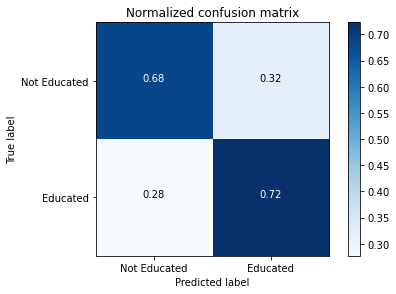

In [49]:
createLabelsCMandPlot(lrPred)

In [50]:
classificationMetrics(lrPred)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|20395|
|    0|       0.0|50311|
|    1|       1.0|53171|
|    0|       1.0|23256|
+-----+----------+-----+

precision: 0.696
recall: 0.723
accuracy: 0.703
F1 score: 0.709
AUC: 0.669


### Support Vector Machine Pipeline, Model, Cross Validation and Evaluation

In [51]:
#create a SVM classifier model to pass into pipeline
lsvc = LinearSVC(labelCol = "label", featuresCol = "pca_features", maxIter=10, regParam=0.1)

#creating a pipeline with the pca and model to use in the cross validator
svm_pipeline = Pipeline(stages = [scaler_train, pca_model, lsvc])

In [52]:
#SVM Cross Validation
folds = 3
threads = 5
paramGrid = ParamGridBuilder() \
  .addGrid(pca_model.k, [10, 20, 30]) \
  .addGrid(lsvc.regParam, [1, 5, 10]) \
  .build()

#passs the model with variosu combinations of the parameters and it will pick the best one. Using 3 folds to save time. Check seed=42.
crossval = CrossValidator(estimator = svm_pipeline,\
                                        estimatorParamMaps=paramGrid,\
                                        evaluator = MulticlassClassificationEvaluator(),\
                                        numFolds= folds,seed=seed,
                                        parallelism=threads)


#this is our best model - fit the training data
cv_svm_model = crossval.fit(training_data)

In [53]:
#all the 9 model accuracies. The max one was picked as best
avgMetricsGrid_svm = cv_svm_model.avgMetrics
print(avgMetricsGrid_svm)

[0.36699894577361286]


In [97]:
#Get the hyperparameters from the pca and for the SVM model
svm_bestPipeline = cv_svm_model.bestModel

#pca
svm_pca = svm_bestPipeline.stages[1]
print("Optimal pca k: {}".format(svm_pca.getK()))

#SVM parameters
svm_model = svm_bestPipeline.stages[2]
print("RegParam parameter: {}".format(svm_model.getRegParam()))

Optimal pca k: 10
RegParam parameter: 10.0


In [55]:
#predict and evaluate the svm model
svmPred = cv_svm_model.transform(test_data)

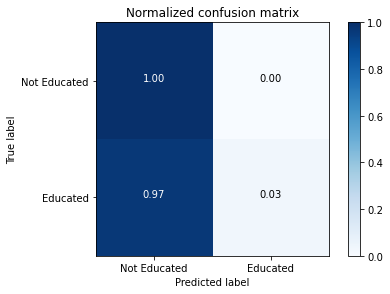

In [56]:
createLabelsCMandPlot(svmPred)

In [57]:
classificationMetrics(svmPred)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|71060|
|    0|       0.0|73567|
|    1|       1.0| 2506|
+-----+----------+-----+

precision: 1.000
recall: 0.034
accuracy: 0.517
F1 score: 0.066
AUC: 0.759


### Gradient Boosting Pipeline, Model, Cross Validation and Evaluation

In [58]:
#create a Gradient Boosting classifier model to pass into pipeline
gb = GBTClassifier(labelCol = "label", featuresCol = "pca_features")

#creating a pipeline with the pca and model to use in the cross validator
gb_pipeline = Pipeline(stages = [scaler_train, pca_model, gb])

In [59]:
#Gradient Boosting Cross Validation
paramGrid = ParamGridBuilder() \
             .addGrid(pca_model.k, [10, 20, 30]) \
             .addGrid(gb.maxDepth, [2, 4, 10]) \
             .addGrid(gb.maxBins, [10, 20]) \
             .addGrid(gb.maxIter, [5, 10]) \
             .build()

#passs the model with variosu combinations of the parameters and it will pick the best one. Using 3 folds to save time. Check seed=42.
crossval = CrossValidator(estimator = gb_pipeline,\
                                        estimatorParamMaps=paramGrid,\
                                        evaluator = MulticlassClassificationEvaluator(),\
                                        numFolds= folds,seed=seed,
                                        parallelism=threads)


#this is our best model - fit the training data
cv_gb_model = crossval.fit(training_data)

In [60]:
#all the 9 model accuracies. The max one was picked as best
avgMetricsGrid_gb = cv_gb_model.avgMetrics
print(avgMetricsGrid_gb)

[0.7419862494710836]


In [95]:
#Get the hyperparameters from the pca and for the GB model
gb_bestPipeline = cv_gb_model.bestModel

#pca
gb_pca = gb_bestPipeline.stages[1]
print("Optimal pca k: {}".format(gb_pca.getK()))

#GB parameters
gb_model = gb_bestPipeline.stages[2]
print("Max depth parameter: {}".format(gb_model.getMaxDepth()))
print("Max bins parameter: {}".format(gb_model.getMaxBins()))
print("Max iter parameter: {}".format(gb_model.getMaxIter()))

Optimal pca k: 10
Max depth parameter: 2
Max bins parameter: 10
Max iter parameter: 5


In [61]:
#predict and evaluate the gb model
gbPred = cv_gb_model.transform(test_data)

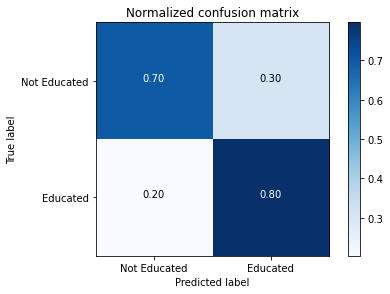

In [62]:
createLabelsCMandPlot(gbPred)

In [63]:
classificationMetrics(gbPred)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|14966|
|    0|       0.0|51394|
|    1|       1.0|58600|
|    0|       1.0|22173|
+-----+----------+-----+

precision: 0.725
recall: 0.797
accuracy: 0.748
F1 score: 0.759
AUC: 0.703


### Random Forest Pipeline, Model, Cross Validation and Evaluation

In [64]:
#create a Random Forest classifier model to pass into pipeline
rf = RandomForestClassifier(labelCol = "label", featuresCol = "pca_features")

#creating a pipeline with the pca and model to use in the cross validator
rf_pipeline = Pipeline(stages = [scaler_train, pca_model, rf])

In [65]:
#Gradient Boosting Cross Validation
paramGrid = ParamGridBuilder() \
        .addGrid(pca_model.k, [10, 20, 30]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .addGrid(rf.numTrees, [20, 30]) \
        .build() 

#passs the model with variosu combinations of the parameters and it will pick the best one. Using 3 folds to save time. Check seed=42.
crossval = CrossValidator(estimator = rf_pipeline,\
                                        estimatorParamMaps=paramGrid,\
                                        evaluator = MulticlassClassificationEvaluator(),\
                                        numFolds= folds,seed=seed,
                                        parallelism=threads)


#this is our best model - fit the training data
cv_rf_model = crossval.fit(training_data)

In [66]:
#all the 9 model accuracies. The max one was picked as best
avgMetricsGrid_rf = cv_gb_model.avgMetrics
print(avgMetricsGrid_rf)

[0.7419862494710836]


In [102]:
#Get the hyperparameters from the pca and for the RF model
rf_bestPipeline = cv_rf_model.bestModel

#pca
rf_pca = rf_bestPipeline.stages[1]
print("Optimal pca k: {}".format(rf_pca.getK()))

#RF parameters
rf_model = rf_bestPipeline.stages[2]
print("Max depth parameter: {}".format(rf_model.getMaxDepth()))
print("Num Trees parameter: {}".format(rf_model.getNumTrees()))

Optimal pca k: 10
Max depth parameter: 5


TypeError: 'int' object is not callable

In [67]:
#predict and evaluate the gb model
rfPred = cv_rf_model.transform(test_data)

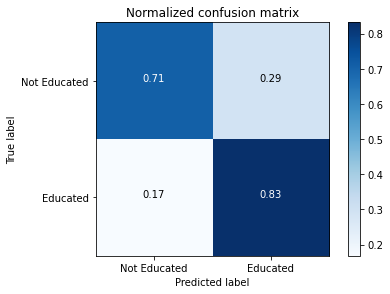

In [68]:
createLabelsCMandPlot(rfPred)

In [69]:
classificationMetrics(rfPred)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|12391|
|    0|       0.0|52130|
|    1|       1.0|61175|
|    0|       1.0|21437|
+-----+----------+-----+

precision: 0.741
recall: 0.832
accuracy: 0.770
F1 score: 0.783
AUC: 0.720
